### N-gram Language Model from Scratch
Exercise 3-6 from Neural Machine Translation and Sequence-to-sequence Models: A Tutorial by 
Graham Neubig (https://arxiv.org/abs/1703.01619)

In [107]:
# imports
import numpy as np
from nltk.util import everygrams
from collections import Counter
import matplotlib.pyplot as plt

# max N-gram length
N = 10
# interpolation parameter
alpha = 0.1

# load data
train = open("en-de/train.en-de.low.filt.en", "r", encoding="UTF-8").readlines()
test = open("en-de/test.en-de.low.en", "r", encoding="UTF-8").readlines()

In [108]:
# split and pad training sentences
padded_train = []
for sentence in train:
    padded_train.append(["<s>"]*N + sentence.strip().split() + ["</s>"])

In [109]:
# count N-grams for every N
counter = Counter()
for sentence in padded_train:
    counter.update(everygrams(sentence,1,N))

# build vocabulary
len_train = 0
vocab = set()
for item, count in counter.items():
    if len(item) == 1:
        vocab.add(item[0])
        len_train += count

In [ ]:
# split and pad test sentences
padded_test = []
for sentence in test:
    # Replace out-of-vocab words with UNK tokens
    padded_test.append(["<s>"]*N + [word if word in vocab else "<unk>" for word in sentence.strip().split()] + ["</s>"])

In [115]:
# compute the probability of the word given a past window
def theta_et(window, current):
    # in case of word not in vocabulary, assume uniform distribution over english language of ~10M words
    if current == "<unk>":
        return 1e-6
    # count n-gram occurences
    whole = counter[tuple(window+current)]
    past = counter[tuple(window)]
    # if window has never been encountered before return 0 to prevent error
    if past == 0:
        return 0
    # else return the probability
    else:
        # instances of entire sequence out of instances of window
        return whole/past

# compute the probability of the current word given a window, using maximum likelihood estimation
def ML(window, current):
    # if it's the beginning of the sentence, return the base probability of the word
    if len(window) == 0:
        return counter[tuple(current)]/len_train
    # else, compute the probability given the window
    else:
        # compute the probability given the entire window   
        current_order = theta_et(window, current)
        # recoursively compute the probability for smaller windows
        higher_orders = ML(window[1:], current)
        # compose the probabilities with smoothing
        return (1-alpha)*current_order + alpha*higher_orders

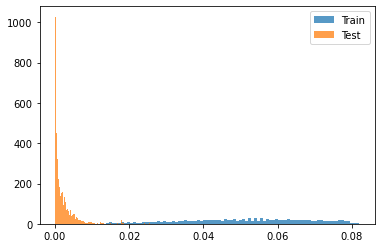

In [119]:
# score model on train and test sets
train_scores = []
test_scores = []

# for each word in each sentence
for sentence in padded_train:
    sentence_score = 0
    for i in range(N,len(sentence)):
            # compute probability of word according to model
            sentence_score += ML(sentence[i-N:i],[sentence[i]])
    # normalize by length of sentence
    train_scores.append(sentence_score/len(sentence))

# as above
for sentence in padded_test:
    sentence_score = 0
    for i in range(len(sentence)):
        if i >= N:
            sentence_score += ML(sentence[i-N:i],[sentence[i]])
    test_scores.append(sentence_score/len(sentence))

# plot scores as histograms
_ = plt.hist(train_scores,100,density=True,alpha=0.75,label="Train")
_ = plt.hist(test_scores,100,density=True,alpha=0.75,label="Test")
plt.legend()
plt.show()

In [104]:
# define prediction functions

def greedy_search_step(past):
    best_word = ""
    best_score = 0
    # for each word in vocab except padding token
    for word in list(vocab-set(["<s>"])):
        # compute probability given past
        score = ML(past[N:],[word])
        # choose most probable word in dictionary
        if score > best_score:
            best_score = score
            best_word = word
    return best_word

def random_search_step(past):
    words = []
    scores = []
    # for each word in vocab except padding token
    for word in list(vocab-set(["<s>"])):
        words.append(word)
        # compute probability given past and append to distribution
        scores.append(ML(past[N:],[word]))
    # normalize distribution
    probabilities = np.array(scores)/np.sum(np.array(scores))
    # sample word from distribution
    return np.random.choice(words, p = probabilities)

# predict sentence given seed and length
def search(seed, length, strat="greedy"):
    sentence = seed.split()
    for _ in range(length):
        # halt if end sentence token predicted
        if sentence[-1] == "</s>":
            return " ".join(sentence)
        # predict word
        if strat == "greedy":
            prediction = greedy_search_step(sentence)
        if strat == "random":
            prediction = random_search_step(sentence)
        # append to predicted sentence
        sentence.append(prediction)
    return " ".join(sentence)

In [122]:
# test generation

seed = "the little man had"
length = 10
print(search(seed, length, "greedy"))
print(search(seed, length, "random"))

the little man had , , , , , , , and i 'm
the little man had what people going a know teenage there are in the


In [123]:
seed = "the little woman had"
length = 10
print(search(seed, length, "greedy"))
print(search(seed, length, "random"))

the little woman had , , , , , , , and i 'm
the little woman had comes down . kind , , years ago . </s>


fin.